# Anomaly Detection Notebook

Let's build this machine learning model using the Isolation Forest Method to find anomalies in the denied transactions

## 1. Import Libraries

In [74]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from datetime import datetime

## 2. Loading Data

In [54]:
data = pd.read_csv('../data/Transactions/transactions_1.csv')

print(data.head())

     time    status  f0_
0  00h 00  approved    9
1  00h 00    denied    6
2  00h 00  refunded    1
3  00h 01    denied    8
4  00h 01  approved   13


## 3. Data Preprocessing

In [55]:
# Convert the 'time' column to datetime format
data['time'] = pd.to_datetime(data['time'], format='%Hh %M')

# Create a numeric column for status for machine learning model
data['status_num'] = data['status'].astype('category').cat.codes

In [56]:
data

,time,status,f0_,status_num
0,1900-01-01 00:00:00,approved,9,0
1,1900-01-01 00:00:00,denied,6,2
2,1900-01-01 00:00:00,refunded,1,5
3,1900-01-01 00:01:00,denied,8,2
4,1900-01-01 00:01:00,approved,13,0
...,...,...,...,...
4229,1900-01-01 23:59:00,processing,4,4
4230,1900-01-01 23:59:00,denied,1,2
4231,1900-01-01 23:59:00,backend_reversed,5,1
4232,1900-01-01 23:59:00,approved,10,0


## 4. Data Visualization

Let's visualize all the data and spot the anomalies

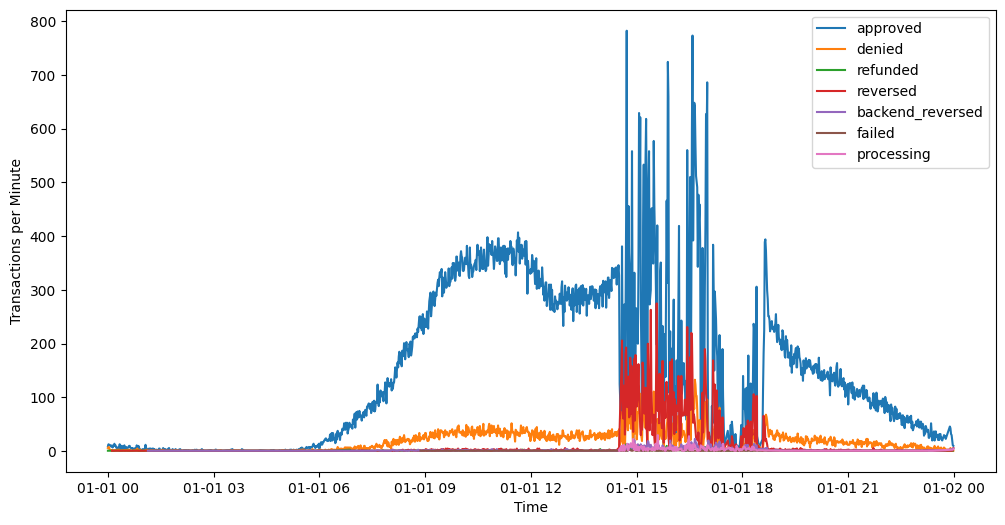

In [57]:
# View transaction graph per minute for each status
plt.figure(figsize=(12, 6))
for status in data['status'].unique():
    plt.plot(data[data['status'] == status]['time'], data[data['status'] == status]['f0_'], label=status)

plt.xlabel('Time')
plt.ylabel('Transactions per Minute')
plt.legend()
plt.show()

We can easy see a point where the anomalies can be found. Lets build a model that detects this behavior

## 5. Building the Anomaly Detection Model

In [58]:
# Select relevant features
FEATURES = ['status_num', 'f0_']

# Train the Isolation Forest model
model = IsolationForest(contamination=0.25, random_state=42) # Adjust as needed
model.fit(data[FEATURES])


C:\Users\Pedro Natanael\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.25, random_state=42)

In [59]:
# Create a column with the scores
data['anomaly_scores'] = model.decision_function(data[FEATURES])

In [60]:
# Create a column to evaluate the score
data['anomaly'] = model.predict(data[FEATURES])

In [61]:
# Counting the number of anomalies the model found in all transactions per minute
data[data['anomaly'] == -1].groupby("status")['f0_'].agg("count").reset_index()

,status,f0_
0,approved,567
1,backend_reversed,34
2,denied,74
3,failed,53
4,processing,69
5,refunded,56
6,reversed,205


This model found many anomalies in others indicators, but we are interested only in "denied" transactions, wich we will see in the graphic bellow

## 6. View Anomalies

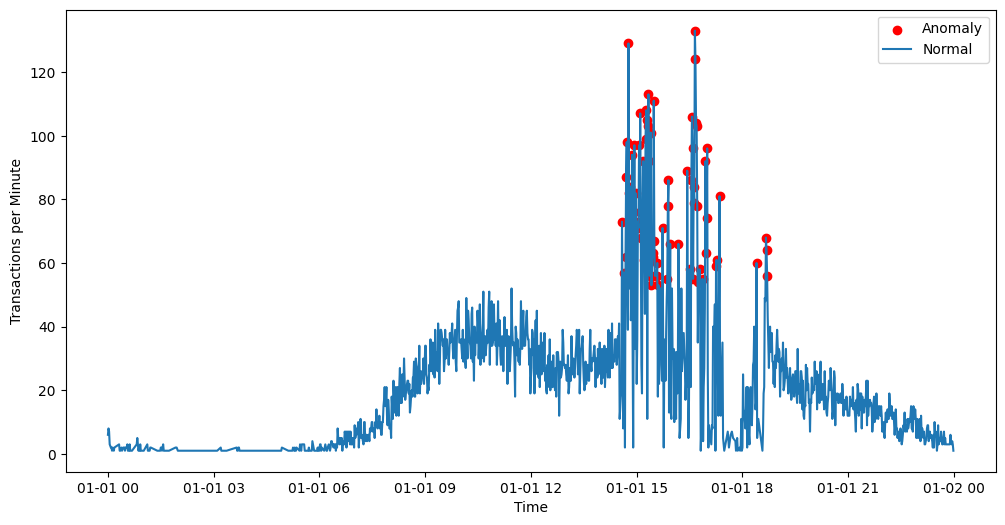

In [64]:
# View anomalies in denied transactions
plt.figure(figsize=(12, 6))
plt.scatter(data[(data['anomaly'] == -1) & (data['status'] == 'denied')]['time'], data[(data['anomaly'] == -1) & (data['status'] == 'denied')]['f0_'], color='red', label= 'Anomaly')
plt.plot(data[data['status'] == 'denied']['time'], data[data['status'] == 'denied']['f0_'], label='Normal')

plt.xlabel('Time')
plt.ylabel('Transactions per Minute')
plt.legend()
plt.show()

In [69]:
data[(data['anomaly'] == -1) & (data['status'] == 'denied') & (data['anomaly_scores'] < 0)]

,time,status,f0_,status_num,anomaly_scores,anomaly
2105,1900-01-01 14:35:00,denied,73,2,-0.046393,-1
2123,1900-01-01 14:38:00,denied,57,2,-0.011433,-1
2137,1900-01-01 14:41:00,denied,62,2,-0.035466,-1
2141,1900-01-01 14:42:00,denied,87,2,-0.073771,-1
2149,1900-01-01 14:43:00,denied,98,2,-0.082670,-1
...,...,...,...,...,...,...
2999,1900-01-01 17:21:00,denied,81,2,-0.067213,-1
3246,1900-01-01 18:24:00,denied,60,2,-0.028505,-1
3289,1900-01-01 18:40:00,denied,68,2,-0.043999,-1
3292,1900-01-01 18:41:00,denied,64,2,-0.038655,-1


As we can see, the model correctly predicted 74 points where there is anomalies in the process. Let's use this model to implement the API

In [71]:
with open('../models/IF_model.pkl','wb') as file_model:
    pickle.dump(model, file_model)

In [73]:
df_input = pd.DataFrame([dict(status_num=2, f0_=2)])
output = model.predict(df_input)[0]
output

1

In [88]:
current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:00-03")
current_datetime

'2024-03-11 01:55:00-03'